Import Dependencies

In [ ]:
#https://pypi.org/project/fastai/

#If installing using anaconda
#! conda install -c fastai -c pytorch -c anaconda fastai gh anaconda 

#If installing using pip install pytorch first 
#!pip install fastai
import zipfile
from fastbook import *
from fastai.vision.widgets import *

Unzip folder I uploaded to gradient notebook service

In [ ]:
path = Path()
x = path.ls(file_exts='.zip')
print(x)

with zipfile.ZipFile(x[0], 'r') as zip_ref:
    zip_ref.extractall(path)

In [16]:
path = Path('roofs') #all my images are in a folder called 'roofs'
print(path)
dls = ImageDataLoaders.from_folder(path, valid_pct = 0.2,seed=42, item_tfms=Resize(224))

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(8)

roofs


epoch,train_loss,valid_loss,error_rate,time
0,2.065266,3.269204,0.636364,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.988524,2.418427,0.636364,00:02
1,1.821239,1.874673,0.636364,00:03
2,1.645112,1.319565,0.545455,00:03
3,1.367248,0.953017,0.227273,00:03
4,1.201183,0.841312,0.181818,00:03
5,1.040292,0.812057,0.181818,00:02
6,0.926093,0.822727,0.181818,00:03
7,0.823949,0.812791,0.181818,00:03


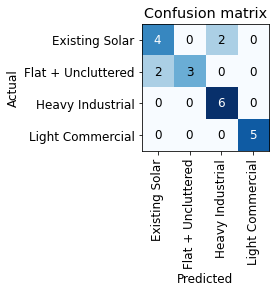

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The first 4 rows are all incorrect predictions

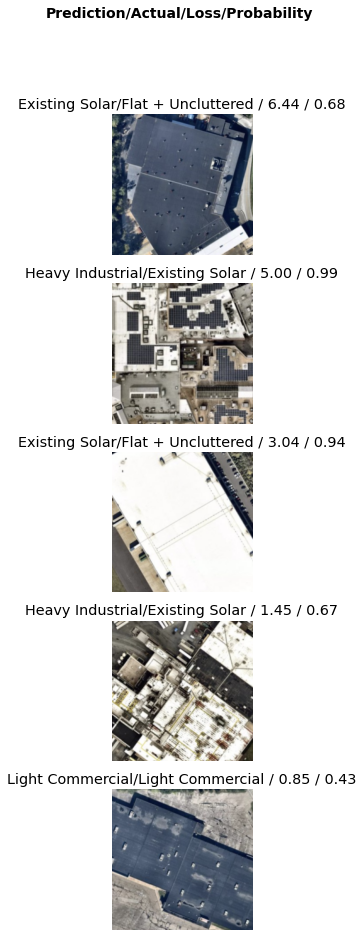

In [19]:
interp.plot_top_losses(5, nrows=5)

Now I will augment the images to hopefully make the model more accurate